# The Content of this chapter

- Look at the big picture
- Get the data
- Discover and visualized the data to gain insights
- prepare the data for ML algorithms
- select a model and train it
- fine-tune your model
- present your solution
- launch, monitor, and maintain your system


# Popular Opena Data Repositories

- http://archive.ics.uci.edu/ml/index.php
- https://www.kaggle.com/datasets
- https://registry.opendata.aws/



# First Task

### Build model to predict hous pricing in California using the California census data


# Performance Measure


<img src='../img/rmse.png'>
<img src='../img/rmse_notation_1.png'>
<img src='../img/rmse_notation_2.png'>

In [1]:
import pandas as pd
import os

In [2]:
def load_housing_data():
    return pd.read_csv('housing.csv')

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

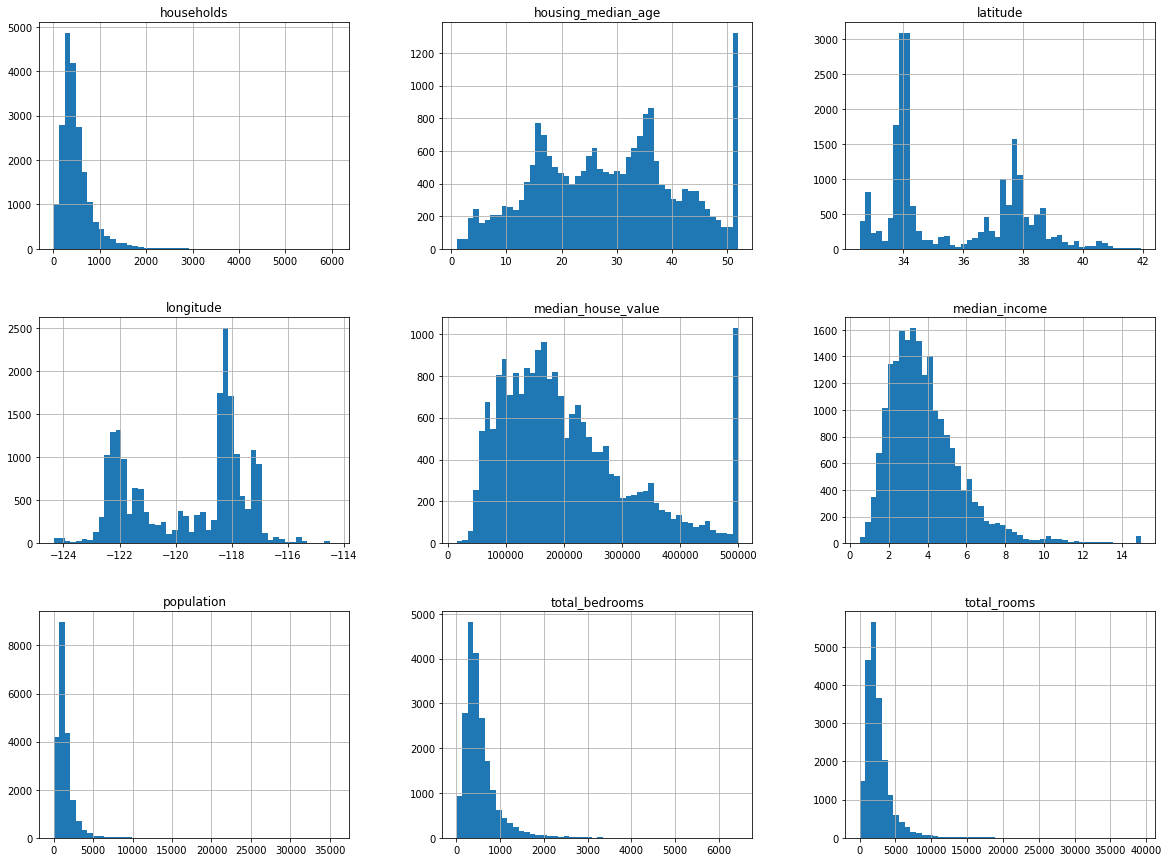

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
# train test split
import numpy as np


def train_test_split(data, test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = train_test_split(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [9]:
# another way to split data
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(housing, test_size=0.2, random_state=42)

In [10]:
len(X_train), len(X_test)

(16512, 4128)

**Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices.**


plot the category of median_income to 5 class, taht is 1 to 5 class. class 1 mean the income in range between 0 to 15.000 (or less than 15.000), category 2 means the range between 15.000 to 30.000, and so on

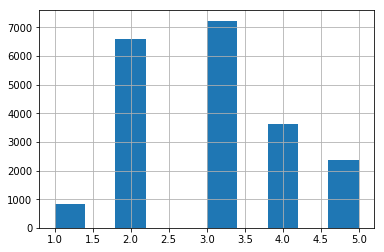

In [11]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins=[0., 1.5, 3., 4.5, 6., np.inf],
                               labels=[1,2,3,4,5])
housing['income_cat'].hist()

## Stratified Sampling based on income category

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]
    
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

# Exploring the Data

## Visualize Geographical Data [only plot the training set of the data]

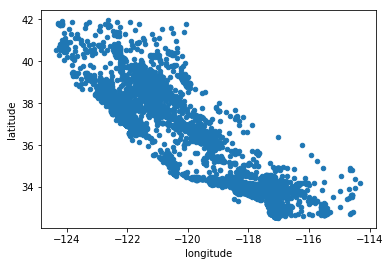

In [13]:
housing = strat_train_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude')

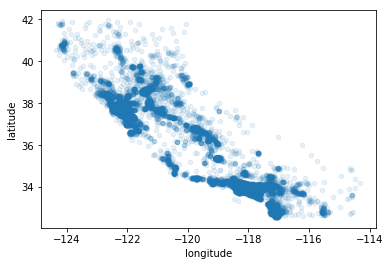

In [14]:
# or
# using alpha=0.1 to visualize easier the place where there is a high density of data points

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

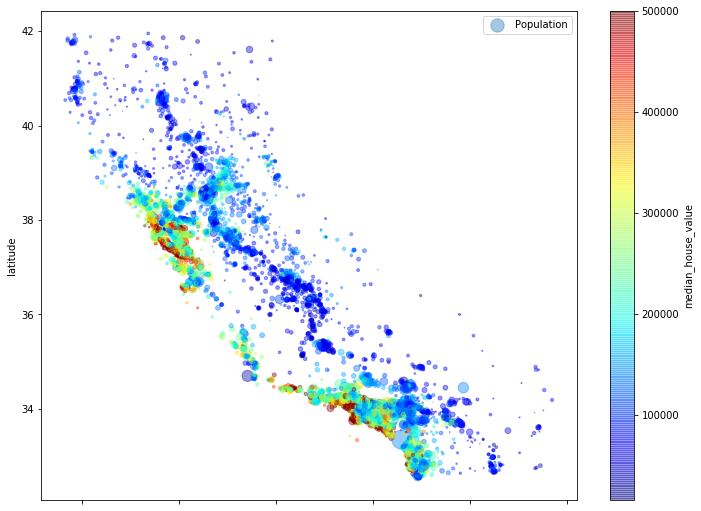

In [15]:
# plot the house price radius

housing.plot(kind="scatter", x='longitude', y='latitude', alpha=0.4, 
             s=housing['population']/100, 
             label='Population', 
             figsize=(12,9), 
             c='median_house_value', 
             cmap=plt.get_cmap('jet'), 
             colorbar=True)

plt.legend()

## Looking for Correlations

is the standard correlation coefficient (Pearson's) between every pair of attribute using <br>

```
corr()
```

In [16]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The crelation coefficient ranges from -1 to 1. When it is close to 1 taht menas :<br>
**That there is a strong positive correlation;** ***for example, the median house value tends to go up when the median income goes up.<br>***
<br>When the coefficient is close to -1 it emans:<br>
**That there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value,**  ***for exampleprice have slight tendency to go down when you go north***

## Another way to check correlation between attributes

in this case, we only plot correlation between median_house_value, median_income, total_rooms, housing_median_age

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcf61bb438>,
      dtype=object)

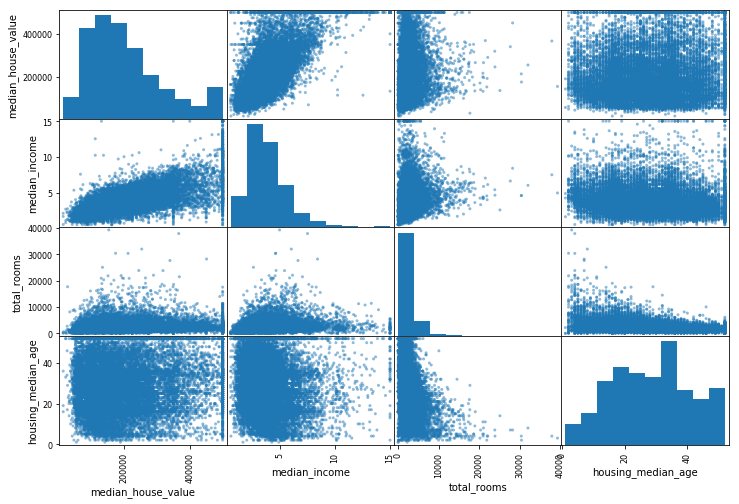

In [17]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12,8))

## The most promising attribute to predict the median house value is the median_income

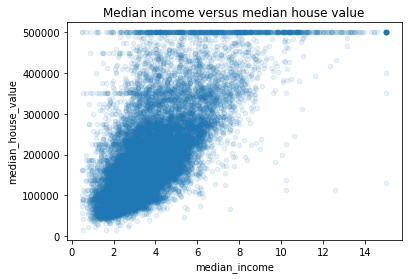

In [18]:
%matplotlib inline
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, title='Median income versus median house value')

## Experiment with Attribute Combinations

In this section we will yo try out various attribute combinations. For example, ***the total number of rooms*** in a district is not very useful if you don't know how many households there are.
***What you really want is the number of rooms per household***


Similarly, the ***total number of bedrooms by itself is not very useful*** you probably to ***compare it to the number of rooms***


and the ***population per household*** also seems like an interesting attribute to look at.

In [19]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_household'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

# looks the new correlation matrix again bellow
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_household     -0.259984
Name: median_house_value, dtype: float64

In [20]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3,4.505810,0.231341,3.047847


# Finally . . . !
# Prepare the Data for ML Algorithms

In [21]:
# make duplicate data for training set ()

housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [22]:
len(housing)

16512

Remove NaN value from dataset in column total_bedrooms


<img src='../img/preprocess_data_1.png'>


- option 1 ===> drop NaN from dataset
- option 2 ===> drop *COLUMNS_NAME* in datset
- option 3 ===> fill NaN using median value

In [23]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3


In [24]:
from sklearn.impute import SimpleImputer

In [25]:
imputer = SimpleImputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

## Handling Text and Categorical Attributes

In [26]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [27]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [28]:
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoder[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [29]:
# get the list of categories

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Another way to convert text or categorical data


<img src='../img/1hot_encoder.png'>
<br><br>
<img src='../img/1hot_encoder_res.png'>


In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Feature Scaling and Transformation

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [32]:
num_pipeline = Pipeline([
    ('inputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [33]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## Column Transformer on Scikit-Learn


How it works :
1. we import ColumnTransformer Class
2. get the list numerical column names and the list of categorical column names
3. construct a Columntransformer to housing dakta


In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipline.fit_transform(housing)

# Select and Train a Model

In [39]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [41]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipline.transform(some_data)
print('Predictions : ', lin_reg.predict(some_data_prepared))

Predictions :  [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]


In [42]:
print('labels : ', list(some_labels))

labels :  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [45]:
from sklearn.metrics import mean_squared_error


housing_pred = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_pred)
lin_rmse = np.sqrt(lin_mse)
print('RMS :\n', lin_rmse)

RMS :
 68376.64295459937


the result of RMSE is 68376.64295459937... is better than nothing but clearly not a great score : <span class="mark">most district median_housing_value range USD120.000 and USD265.000, sp typical prediction error of USD68.628</span>

## More Complex Model

In [47]:
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [48]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
rmse_score = np.sqrt(tree_mse)
print('RMSE DC : \n', rmse_score)

RMSE DC : 
 0.0


Not Error at All...? could this model realy absolutely perfect? Of Course... its much more likely <span class="burk">the model has badly overfit the data.</span> 

# Better Evaluation Using Cross-Validation


one way to evaluate Tree Model is using <span class="girk">train_split_test</span> function to split the training set into a smaller training set and a validate set, then train models gaints the smaller set anf evaluate them againts the validat.ion set.

In [51]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(tree_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring='neg_mean_squared_error', 
                         cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [54]:
def display_scores(scores):
    print('Scores : \n', scores)
    print('Mean : \n', scores.mean())
    print('STD : \n', scores.std())
    
display_scores(tree_rmse_scores)

Scores : 
 [70623.92493884 67773.29273242 68926.02748662 69403.60807776
 72238.98702361 75288.24834025 71529.09080434 72272.04019358
 75726.6825071  70171.12585918]
Mean : 
 71395.3027963698
STD : 
 2463.5544292673417


Acording to the result : the DT model is overfitting so badly taht it performs worse than LinearRegression Model.

In [60]:
# Using RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor



forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_pred = forest_reg.predict(housing_prepared)

/home/rog/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [62]:
forest_mse = mean_squared_error(housing_labels, forest_pred)
forest_rmse = np.sqrt(forest_mse)
print('Forest RMSE : \n', forest_rmse)

Forest RMSE : 
 22208.624388117525


<span class="girk">Is much better than previous model, this is look very promising</span>

## Save RF-Model

In [63]:
from sklearn.externals import joblib


joblib.dump(forest_reg, 'forest_model.pkl')
# and to load the model is
# my_model_loaded = joblib.load('forest_model.pkl')

['forest_model.pkl']